In [3]:
%matplotlib inline

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import time
from sklearn.externals import joblib

In [4]:
user_listen = pd.read_csv('../Datasets/Copy of explicit_data - Data preprocessing - songs.csv')
songs = pd.read_csv('../Datasets/Copy of explicit_data - Songs - All.csv')
songs_with_artist_id = pd.read_csv('../Datasets/Copy of explicit_data - Songs - All-with artist_id.csv')

In [5]:
def merge_data(user_listen, songs):
    merged_data = pd.merge(user_listen, songs.drop_duplicates(['song_id']), on="song_id", how="left")
    merged_data['song'] = merged_data[['Title', 'Artist']].apply(lambda x: ' - '.join(x), axis=1)
    merged_data['listened_song'] = np.ones((441,), dtype=int)
    return merged_data

In [6]:
dataset_df = merge_data(user_listen, songs)

In [7]:
# merge title and artist to a one column
dataset_df['song'] = dataset_df[['Title', 'Artist']].apply(lambda x: ' - '.join(x), axis=1)
dataset_df['song'] 

0                              Sandaganawa - Dhanith Sri
1      Api hagum walata ida dee mohothak - Victor Rat...
2                        Mandaram Wahi Watena - 6th Lane
3                           Ru Sara - Bathiya & Santhush
4                Adanne Ay Sudu Manike - H. R. Jothipala
                             ...                        
436       Nadee Ganga Tharanaye - Chitral Chity Somapala
437    Nimnawiye - IRAJ ft. Nadeera, Shermaine Willis...
438    Tharuka Pelin Eha - Athula Adikari & Samitha M...
439           Mage punchi rosa male  -  Amarasiri Peiris
440    Hanthana Sihine(Bala Walapemi) - W D Amaradeva...
Name: song, Length: 441, dtype: object

In [8]:
# get the count of song_id values
song_grouped = dataset_df.groupby(['song']).agg({'song_id': 'count'}).reset_index()

# get the sum of listen_count column
grouped_sum = song_grouped['song_id'].sum()
print(grouped_sum)

# calculate the percentage of each count
song_grouped['percentage']  = song_grouped['song_id'].div(grouped_sum)*100

# sort the values to get an overview of the popular songs
song_grouped.sort_values(['song_id', 'song'], ascending = [0,1])
# use that to recommend top -N

441


,song,song_id,percentage
186,Sandaganawa - Dhanith Sri,18,4.081633
89,Kuweni - Ridma Weerawardena ft Dinupa Kodagoda,16,3.628118
151,Pandama - Danith Sri,14,3.174603
187,Sandanari - Harsha Withanage,9,2.040816
160,Prathihari - Supun Perera,8,1.814059
...,...,...,...
217,Unmada chithra - Kavindya Adikari & Sahan Cham...,1,0.226757
220,Wakkada Langa(Kaluu) - W D Amaradeva,1,0.226757
221,Wala thiryen eha - T.M.Jayaratne,1,0.226757
222,Walithara Athare Himihita Basina - W D Amaradeva,1,0.226757


In [38]:
# count the number of unique users and songs
users_agegroup = dataset_df['age_group'].unique()
print(len(users_agegroup))
songs = dataset_df['song'].unique()
print(len(songs)) 

3
227


In [9]:
users = dataset_df['user_id'].unique()

In [10]:
train_data, test_data = train_test_split(dataset_df, test_size = 0.20, random_state=0)
print(train_data.head(5))

     user_id age_group  gender     profession hours_spending  \
74     10075   18 - 24  Female        Student          2 - 3   
26     10027   18 - 24    Male       Marketer          2 - 3   
45     10045   25 - 34    Male  Undergraduate          2 - 3   
369    10367   18 - 24  Female        Student          0 - 1   
154    10155   18 - 24  Female        Student          0 - 1   

                musical_aspect  song_id                         Title  \
74                       Music       78               Kohe Yannada Ma   
26   The instrument being used      151  Ra Ahasin Wetena Bindu Bindu   
45          The singer's voice      176             Sandawathiya Obai   
369         The singer's voice      110                  Mihirawa Awa   
154                      Music       81                       Landune   

               Artist  Artist_id     Album  Release Year  \
74        Bachi Susan       10.0  No Album           NaN   
26      Kasun Kalhara        5.0       NaN           NaN

# Top N Recommendation

In [11]:
# class for popularity based Recommender System model class
class popularity_recommender_py:
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.popularity_recommendations = None
    
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

        # get a count of user_ids for each unique song as recommendation score
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)

        # Sort the songs based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])

        # Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')

        # Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(10) 

        # Use the popularity based recommender system model to make recommendations

    def recommend(self, user_id):
        user_recommendations = self.popularity_recommendations

        #Add user_id column for which the recommendations are being generated
            
        user_recommendations['user_id'] = user_id

        # Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols]
        return user_recommendations


In [12]:
pm = popularity_recommender_py()

In [13]:
pm.create(train_data, 'user_id', 'song')

# Item -Item Similarity based

In [14]:
# Class for Item similarity based Recommender System model
class item_similarity_recommender_py:
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.cooccurence_matrix = None
        self.songs_dict = None
        self.rev_songs_dict = None
        self.item_similarity_recommendations = None
    
    # Get unique items (songs) corresponding to a given user
    def get_user_items(self, user):
        user_data = self.train_data[self.train_data[self.user_id] == user]
        user_items = list(user_data[self.item_id].unique())
        
        return user_items
    
    # Get unique users for a given item (song)
    def get_item_users(self, item):
        item_data = self.train_data[self.train_data[self.item_id] == item]
        item_users = set(item_data[self.user_id].unique())
        
        return item_users
    
    # Get unique items (songs) in the training data
    def get_all_items_train_data(self):
        all_items = list(self.train_data[self.item_id].unique())
        
        return all_items
    
    # Construct cooccurence matrix
    def construct_cooccurence_matrix(self, user_songs, all_songs):
        user_songs_users = []
        for i in range(0, len(user_songs)):
            user_songs_users.append(self.get_item_users(user_songs[i]))
            
         ###############################################
         #Initialize the item cooccurence matrix of size 
         #len(user_songs) X len(songs)
         ###############################################  
            
        cooccurence_matrix = np.matrix(np.zeros(shape=(len(user_songs), len(all_songs))), float)
        
        #############################################################
        #Calculate similarity between user songs and all unique songs
        #in the training data
        #############################################################
        
        for i in range(0, len(all_songs)):
            # Calculate unique listeners (users) of song (item) i
            songs_i_data = self.train_data[self.train_data[self.item_id] == all_songs[i]]
            users_i = set(songs_i_data[self.user_id].unique())
            
            for j in range(0, len(user_songs)):
                # Get unique listeners (users) of song (item) j
                users_j = user_songs_users[j]
                
                # Calculate intersection of listeners of songs i and j
                users_intersection = users_i.intersection(users_j)
                
                # Calculate cooccurence_matrix[i,j] as Jaccard Index
                if len(users_intersection) != 0:
                    # Calculate union of listeners of songs i and j
                    users_union = users_i.union(users_j)
                    
                    cooccurence_matrix[j,i] = float(len(users_intersection))/float(len(users_union))
                
                else:
                    cooccurence_matrix[j,i] = 0
                    
        return cooccurence_matrix
    
    # Use the cooccurence matrix to make top recommendations
    def generate_top_recommendations(self, user, cooccurence_matrix, all_songs, user_songs):
        print("Non zero values in cooccurence_matrix :%d" % np.count_nonzero(cooccurence_matrix))
        
        # Calculate a weighted average of the scores in cooccurence matrix for all user songs.
        user_sim_scores = cooccurence_matrix.sum(axis=0)/float(cooccurence_matrix.shape[0])
        user_sim_scores = np.array(user_sim_scores)[0].tolist()
        
        # Sort the indices of user_sim_scores based upon their value Also maintain the corresponding score
        sort_index = sorted(((e,i) for i,e in enumerate(list(user_sim_scores))), reverse=True)
    
        # Create a dataframe from the following
        columns = ['user_id', 'song', 'score', 'rank']
        # index = np.arange(1) # array of numbers for the number of samples
        df = pd.DataFrame(columns=columns)
         
        # Fill the dataframe with top 10 item based recommendations
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in user_songs and rank <= 10:
                df.loc[len(df)]=[user,all_songs[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1
        
        # Handle the case where there are no recommendations
        if df.shape[0] == 0:
            print("The current user has no songs for training the item similarity based recommendation model.")
            return -1
        else:
            return df
    
    # Create the item similarity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

    # Use the item similarity based recommender system model to make recommendations
    def recommend(self, user):
        
        ########################################
        #A. Get all unique songs for this user
        ########################################
        user_songs = self.get_user_items(user)    
            
        print("No. of unique songs for the user: %d" % len(user_songs))
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
                
        return df_recommendations
    
    # Get similar items to given items
    def get_similar_items(self, item_list):
        
        user_songs = item_list
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        user = ""
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
         
        return df_recommendations
        

In [15]:
item_similarity = item_similarity_recommender_py()

In [16]:
item_similarity.create(train_data, 'user_id', 'song')

In [23]:
item_similarity.recommend(users[5])

No. of unique songs for the user: 1
no. of unique songs in the training set: 195
Non zero values in cooccurence_matrix :13


,user_id,song,score,rank
0,10014,Prathihari - Supun Perera,0.100000,1
1,10014,Pandama - Danith Dri,0.080000,2
2,10014,Oba apple malak wage - Amarasiri Peiris,0.066667,3
3,10014,Oba Magemai - Ranidu Lankage,0.066667,4
4,10014,Hitha Mithuru Sulaga - Victor Rathnayaka,0.066667,5
5,10014,Surath Suwaya(Nil Warala Pura) - Supun Perera ...,0.066667,6
6,10014,"Galana ganga - Charitha Attalage, Ravi jay",0.058824,7
7,10014,Piyawuna - Indrachapa Liyanage,0.058824,8
8,10014,Hanguman - Hirushi,0.058824,9
9,10014,Saragaye (Niya Rata Mawanawa) - Sanuka Wickram...,0.055556,10


In [107]:
item_similarity.recommend(users[10])

No. of unique songs for the user: 2
no. of unique songs in the training set: 227
Non zero values in cooccurence_matrix :5


,user_id,song,score,rank
0,10024,Aduru kutiya thula - T M Jayarathna,0.25,1
1,10024,Tharuka Pelin Eha - Athula Adikari & Samitha M...,0.00,2
2,10024,Wala thiryen eha - T.M.Jayaratne,0.00,3
3,10024,Master sir - Bathiya n Santhush,0.00,4
4,10024,Anatha maruthe - Rookantha Gunathilake,0.00,5
5,10024,Oba Kamathi Nam - Billy Fernando,0.00,6
6,10024,Me diganthayeee - Rookantha Gunathilaka,0.00,7
7,10024,Adaraneeya Neranjana - Priya Sooriyasena,0.00,8
8,10024,Oba Dakala - Yuki,0.00,9
9,10024,Prasiddiya Ko - Cairo Rich ft. Pazi,0.00,10


In [14]:
item_similarity.get_similar_items(['Sandaganawa - Dhanith Sri'])

no. of unique songs in the training set: 227
Non zero values in cooccurence_matrix :22


,user_id,song,score,rank
0,,Pandama - Danith Dri,0.103448,1
1,,Saragaye (Niya Rata Mawanawa) - Sanuka Wickram...,0.100000,2
2,,Kuweni - Ridma Weerawardena ft Dinupa Kodagoda,0.096774,3
3,,Prathihari - Supun Perera,0.083333,4
4,,Oba apple malak wage - Amarasiri Peiris,0.055556,5
5,,Mage Unmade - Sangeeth Iddamalgoda,0.055556,6
6,,Runawiye - DKM ft. YAKA,0.055556,7
7,,Samawak na - Cairo Rich,0.055556,8
8,,Hitha Mithuru Sulaga - Victor Rathnayaka,0.055556,9
9,,Surath Suwaya(Nil Warala Pura) - Supun Perera ...,0.055556,10


In [109]:
item_similarity.get_similar_items(['Adanne Ay Sudu Manike - H. R. Jothipala'])


no. of unique songs in the training set: 227
Non zero values in cooccurence_matrix :5


,user_id,song,score,rank
0,,Man ithaliye thani una - Danapala Udawaththa,1.0,1
1,,Ra ahase - Billy,1.0,2
2,,Ninda Noyana Handawe - Ranidu Lankage,1.0,3
3,,Hithin yana aya athin alla nawathtannata be - ...,0.5,4
4,,Tharuka Pelin Eha - Athula Adikari & Samitha M...,0.0,5
5,,Aduru kutiya thula - T M Jayarathna,0.0,6
6,,Wala thiryen eha - T.M.Jayaratne,0.0,7
7,,Master sir - Bathiya n Santhush,0.0,8
8,,Anatha maruthe - Rookantha Gunathilake,0.0,9
9,,Oba Kamathi Nam - Billy Fernando,0.0,10


In [17]:
# Evaluation of the Model
import Evaluation as Evaluation

In [18]:
start = time.time()

#Define what percentage of users to use for precision recall calculation
user_sample = 0.05

#Instantiate the precision_recall_calculator class
pr = Evaluation.precision_recall_calculator(test_data, train_data, pm, item_similarity)

#Call method to calculate precision and recall values
(pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

end = time.time()
print(end - start)

Length of user_test_and_training:42
Length of user sample:2
Getting recommendations for user:10049
No. of unique songs for the user: 3
no. of unique songs in the training set: 195
Non zero values in cooccurence_matrix :14
Getting recommendations for user:10436
No. of unique songs for the user: 1
no. of unique songs in the training set: 195
Non zero values in cooccurence_matrix :1
0.3869168758392334


In [19]:
import pylab as pl

#Method to generate precision and recall curve
def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label, m2_precision_list, m2_recall_list, m2_label):
    pl.clf()    
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.plot(m2_recall_list, m2_precision_list, label=m2_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 0.20])
    pl.xlim([0.0, 0.20])
    pl.title('Precision-Recall curve')
    #pl.legend(loc="upper right")
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()


Plotting precision recall curves.


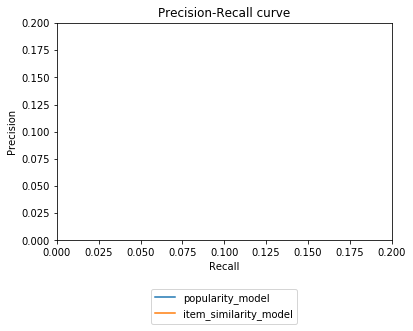

In [20]:
print("Plotting precision recall curves.")

plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")

Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).
Plotting precision recall curves.


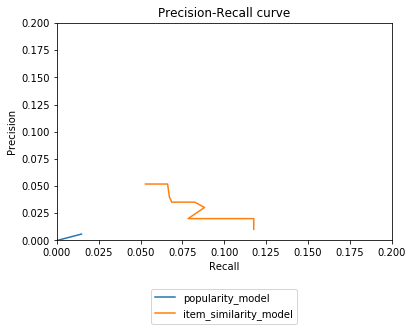

In [21]:
print("Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).")

#Read the persisted files 
pm_avg_precision_list = joblib.load('pm_avg_precision_list_3.pkl')
pm_avg_recall_list = joblib.load('pm_avg_recall_list_3.pkl')
ism_avg_precision_list = joblib.load('ism_avg_precision_list_3.pkl')
ism_avg_recall_list = joblib.load('ism_avg_recall_list_3.pkl')

print("Plotting precision recall curves.")
plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")

Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).
Plotting precision recall curves.


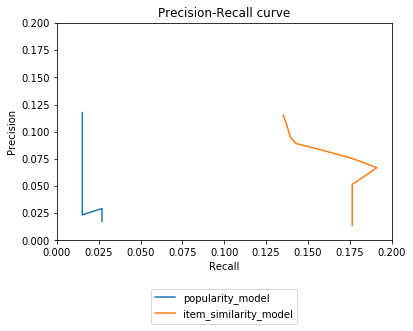

In [22]:
print("Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).")

pm_avg_precision_list = joblib.load('pm_avg_precision_list_2.pkl')
pm_avg_recall_list = joblib.load('pm_avg_recall_list_2.pkl')
ism_avg_precision_list = joblib.load('ism_avg_precision_list_2.pkl')
ism_avg_recall_list = joblib.load('ism_avg_recall_list_2.pkl')

print("Plotting precision recall curves.")
plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")